# ML Ops Zoomcamp

Homework week 1

In [26]:
# Importing libraries

from datetime import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import root_mean_squared_error

In [45]:
# Loading dataset

jandata=pd.read_parquet('yellow_tripdata_2023-01.parquet', engine='pyarrow')

In [ ]:
# Read the data for January. How many columns are there?

print(f'Number of columns: {len(jandata.columns)}')

Number of columns: 19


Now let's compute the duration variable. It should contain the duration of a ride in minutes.What's the standard deviation of the trips duration in January?

In [46]:
jandata['duration'] = (jandata['tpep_dropoff_datetime'] - jandata['tpep_pickup_datetime']).dt.total_seconds() / 60

print(f'Number of columns: {round(np.std(jandata['duration']),2)}')

Number of columns: 42.59


Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive). 
What fraction of the records left after you dropped the outliers?

In [49]:
inital_length=len(jandata['duration'])

print(f'Initial length {inital_length}')

def remove_outliers(df, col, minimum, maximum):
    return df.loc[(df[col]>=minimum) & (df[col]<=maximum)]


new_df=remove_outliers(jandata, 'duration', 1, 60)

new_length=len(new_df['duration'])

print(f'New length {new_length}')

print(f'The fraction of the records left after the outliers were dropped: {round(new_length/inital_length*100,2)}%')

Initial length 3066766
New length 3009173
The fraction of the records left after the outliers were dropped: 98.12%


Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it

 What's the dimensionality of this matrix (number of columns)?

In [57]:
features = ['PULocationID', 'DOLocationID']
new_df.loc[:,features] = new_df[features].astype(str)

dicts = new_df[features].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(dicts)

y_train = new_df['duration'].values

print(f'Feature matrix dimensionality: {X_train.shape[1]}')


Feature matrix dimensionality: 515


Now let's use the feature matrix from the previous step to train a model.

- Train a plain linear regression model with default parameters, where duration is the response variable
- Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [58]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_train_pred)
print(f'RMSE on training data: {rmse_train:.2f}')

RMSE on training data: 7.65


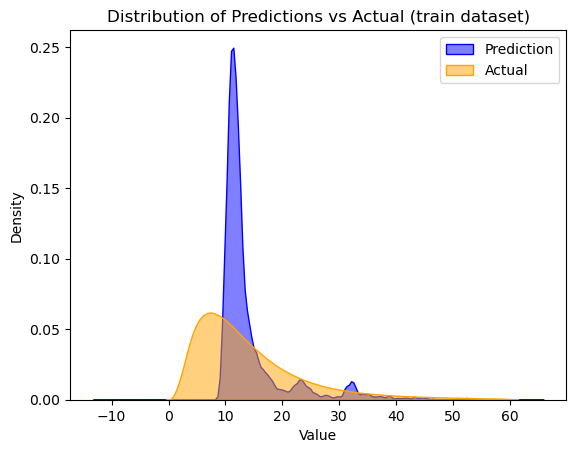

In [62]:
sns.kdeplot(y_train_pred, label='Prediction', fill=True, alpha=0.5, color='blue')
sns.kdeplot(y_train.squeeze(), label='Actual', fill=True, alpha=0.5, color='orange')

plt.legend()
plt.title('Distribution of Predictions vs Actual (train dataset)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


Now let's apply this model to the validation dataset (February 2023).
What's the RMSE on validation?

In [60]:
feb_data=pd.read_parquet('yellow_tripdata_2023-02.parquet', engine='pyarrow')
feb_data['duration'] = (feb_data['tpep_dropoff_datetime'] - feb_data['tpep_pickup_datetime']).dt.total_seconds() / 60
feb_data_filtered = feb_data[(feb_data['duration'] >= 1) & (feb_data['duration'] <= 60)]

feb_data_filtered.loc[:, features] = feb_data_filtered[features].astype(str)
dicts_val = feb_data_filtered[features].to_dict(orient='records')
X_val = dv.transform(dicts_val)

y_val = feb_data_filtered['duration'].values
y_val_pred = lr.predict(X_val)

rmse_val = root_mean_squared_error(y_val, y_val_pred)
print(f'RMSE on validation data: {rmse_val:.2f}')


RMSE on validation data: 7.81


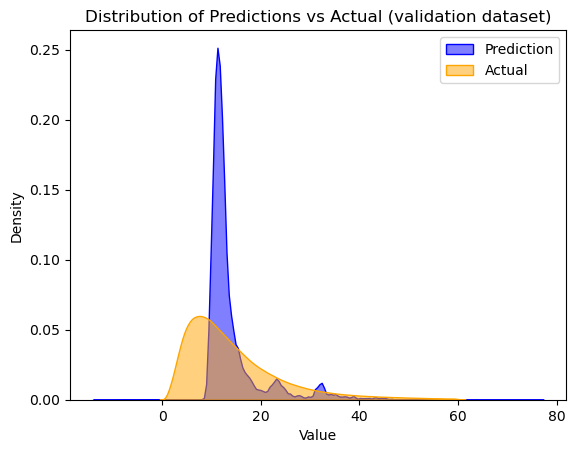

In [61]:
sns.kdeplot(y_val_pred, label='Prediction', fill=True, alpha=0.5, color='blue')
sns.kdeplot(y_val.squeeze(), label='Actual', fill=True, alpha=0.5, color='orange')

plt.legend()
plt.title('Distribution of Predictions vs Actual (validation dataset)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()